In [32]:
# base
import pandas as pd 
import numpy as np
import zipfile
import os
import datetime

# graph
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mapclassify as mc
import seaborn as sns

# force reload to not restart jupyter each time
from importlib import reload

# function
import famDataset
reload(famDataset)

<module 'famDataset' from '/home/tibo/Documents/Github/projet-fil-rouge-TiboGar-1/data/famDataset.py'>

In [33]:
# Init
fam = famDataset.famDataset(root_dir=os.getcwd())

fam.load_transformed_data()

fam.transformed_data

Raw data loading complete
Raw data processed in transformed_data


,ESPECES,DEP,CAMPAGNE,DATE,ENTREE,SORTIE
0,Avoine,01,2000/01,2000-07-01,2407.7,-2247.7
1,Avoine,02,2000/01,2000-07-01,327.7,-327.7
2,Avoine,03,2000/01,2000-07-01,1149.2,-1092.8
3,Avoine,04,2000/01,2000-07-01,45.3,-45.3
4,Avoine,05,2000/01,2000-07-01,120.4,-120.4
...,...,...,...,...,...,...
330919,Triticale,88,2025/26,2025-10-01,1084.1,-1501.0
330920,Triticale,89,2025/26,2025-10-01,222.5,-369.4
330921,Triticale,90,2025/26,2025-10-01,0.0,0.0
330922,Triticale,91,2025/26,2025-10-01,90.8,-433.6


In [34]:
# Init
fam = famDataset.famDataset(root_dir=os.getcwd())

#fam.download_raw_data()
# Load and tranform data
fam.load_transformed_data(convert_attributes = True, drop_attributes = False)
# Load geometry data
fam.load_geometry_data()

fam_data = fam.transformed_data

fam_data.head()

Raw data loading complete
Raw data processed in transformed_data
Geom data loading complete


,ESPECES,DEP,CAMPAGNE,TOTAL_COLLECTE,STOCKS,STOCKS_DEPOTS,ENTREE_DEPOT,SORTIE_DEPOT,REPRISE_DEPOT,DATE,ENTREE,LAG_DIFF,SORTIE
0,Avoine,01,2000/01,2245.9,2642.7,151.0,161.8,0.4,1.4,2000-07-01,2407.7,0.0,-2247.7
1,Avoine,02,2000/01,327.7,900.0,0.0,0.0,0.0,0.0,2000-07-01,327.7,0.0,-327.7
2,Avoine,03,2000/01,1092.8,1620.4,60.4,56.4,0.0,0.0,2000-07-01,1149.2,0.0,-1092.8
3,Avoine,04,2000/01,45.3,117.8,0.0,0.0,0.0,0.0,2000-07-01,45.3,0.0,-45.3
4,Avoine,05,2000/01,120.4,105.2,0.0,0.0,0.0,0.0,2000-07-01,120.4,0.0,-120.4


In [35]:
# compute SORTIE divided by stocks
fam_data['SORTIE_ON_STOCKS'] = fam_data['SORTIE'] / fam_data['STOCKS']

# When Stocks is null, set the variable to null
fam_data.loc[fam_data['STOCKS'] == 0,'SORTIE_ON_STOCKS'] = 0


# compute SORTIE divided by max stocks
# ensure DATE is datetime and sorted
fam_data['DATE'] = pd.to_datetime(fam_data['DATE'])
fam_data = fam_data.sort_values(['ESPECES','DEP','DATE'])

# compute 12-row rolling max of STOCKS within each ESPECES+DEP group
# fam_data['MAX_STOCKS'] = fam_data.groupby(['ESPECES','DEP','CAMPAGNE'])['STOCKS'].rolling(12, min_periods=1).max().reset_index(level=[0,1,2], drop=True)
fam_data['MAX_STOCKS'] = fam_data.groupby(['ESPECES','DEP'])['STOCKS'].rolling(12, min_periods=1).max().reset_index(level=[0,1], drop=True)

fam_data['SORTIE_ON_MAX'] = fam_data['SORTIE'] / fam_data['MAX_STOCKS']

# When Stocks is null, set the variable to null
fam_data.loc[fam_data['MAX_STOCKS'] == 0,'SORTIE_ON_MAX'] = 0


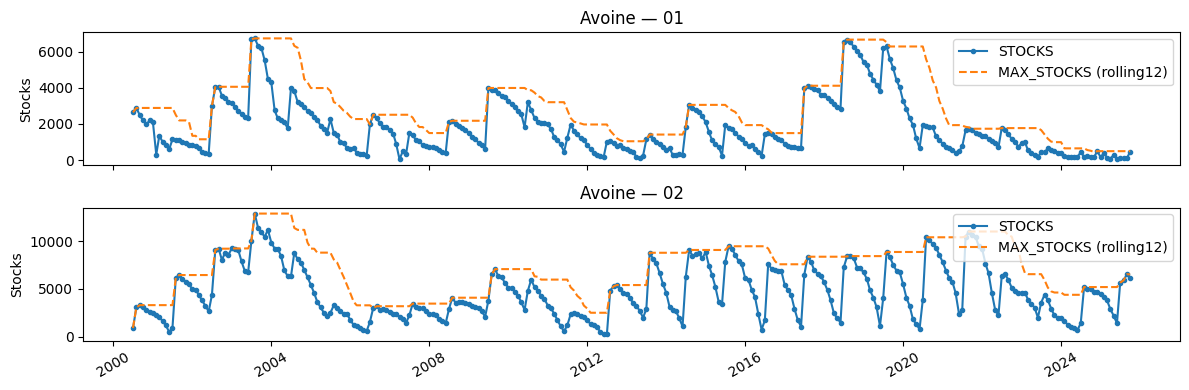

In [36]:

# sample a few ESPECES+DEP combinations for plotting
combos = fam_data.groupby(['ESPECES','DEP']).size().nlargest(2).index.tolist()  # up to 6 largest groups

# filter
plot_df = pd.concat([fam_data[(fam_data['ESPECES']==e)&(fam_data['DEP']==d)].assign(group=f"{e} | {d}") 
                     for e,d in combos])

# plot: STOCKS (points/lines) and MAX_STOCKS (step/line)
#sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(len(combos), 1, figsize=(12, 2*len(combos)), sharex=True)

if len(combos) == 1:
    axes = [axes]

for ax, ((e,d), grp) in zip(axes, zip(combos, [g for g in combos])):
    gdf = plot_df[plot_df['group'] == f"{e} | {d}"].sort_values('DATE')
    ax.plot(gdf['DATE'], gdf['STOCKS'], marker='.', linestyle='-', label='STOCKS')
    ax.plot(gdf['DATE'], gdf['MAX_STOCKS'], marker=None, linestyle='--', color='C1', label='MAX_STOCKS (rolling12)')
    ax.set_title(f"{e} — {d}")
    ax.legend()
    ax.set_ylabel('Stocks')
    ax.xaxis.set_tick_params(rotation=30)

plt.tight_layout()
plt.show()


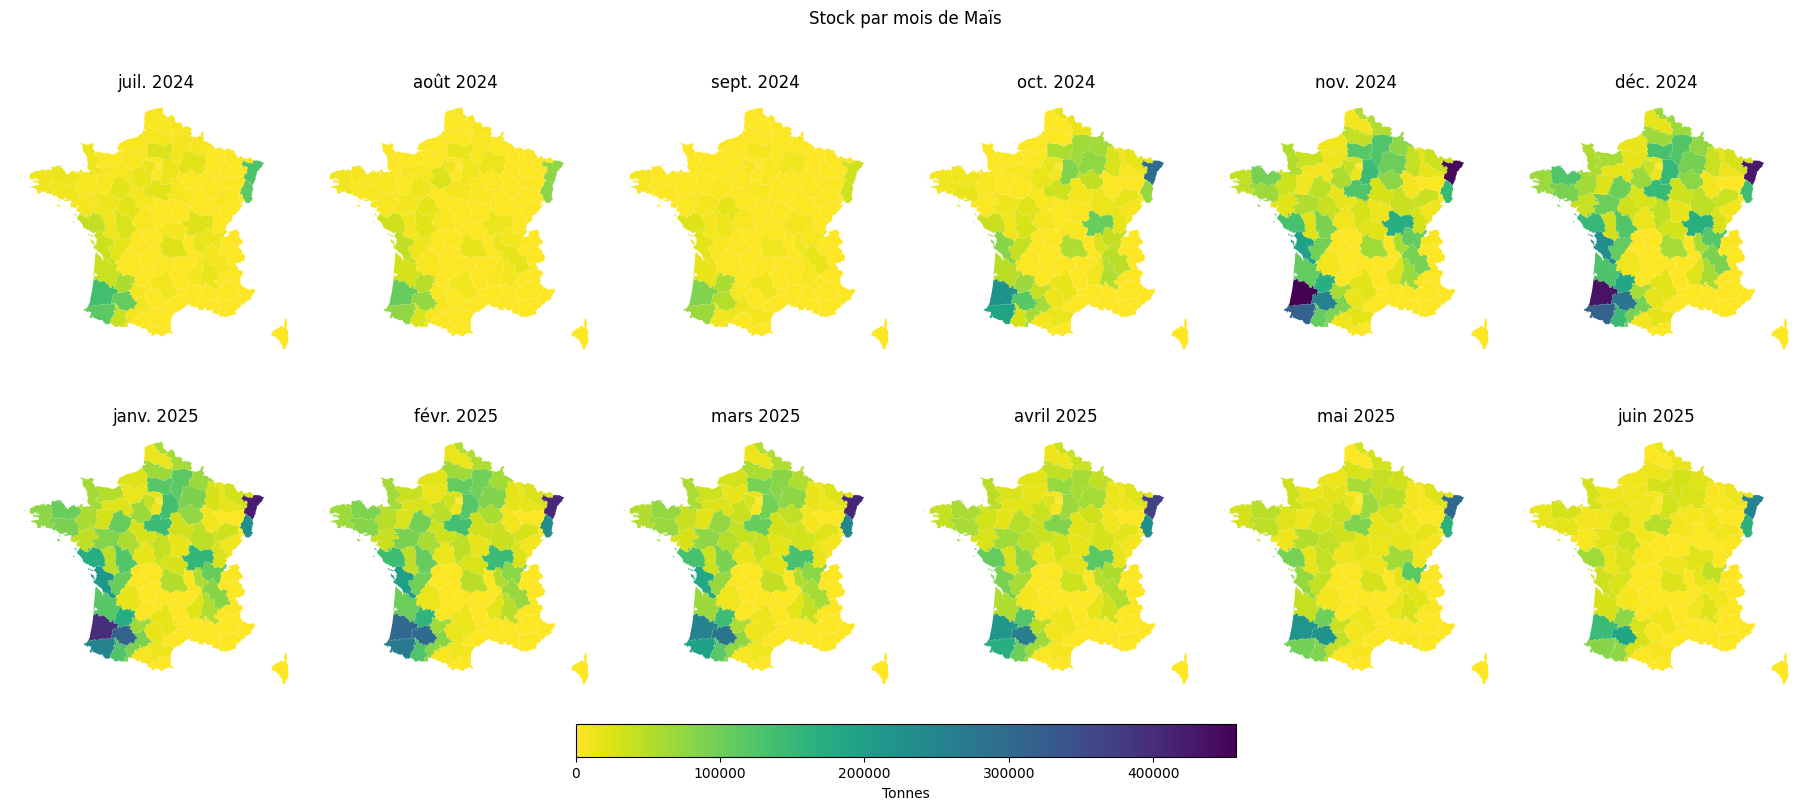

In [37]:
# ------------------------- #
### User Input              #
# ------------------------- #
# Especes :
espece='Blé tendre'
espece='Maïs'
# Year :
map_year = 2024

cmap = mpl.colormaps['viridis_r']

# ------------------------- #
# create st matrix
# ------------------------- #
st = famDataset.make_spatiotemporal_matrix(transformed_data = fam_data,
                                            geom_data = fam.geom_data, 
                                            especes=espece, 
                                            variable='STOCKS')


# Select specific years:
col_trigger = [ii+3 + (map_year-2000)*12 for ii in range(12)]

time_name = st.columns[col_trigger]
title_name = [datetime.datetime.strftime(name,'%b %Y') for name in time_name]

# Add the geometry variable to the trigger
col_trigger.insert(0,0)

current_st = st.iloc[:,col_trigger]

# Compute some stats
max_fam = np.max(current_st.iloc[:,1:])
mean_fam = np.mean(current_st.iloc[:,1:])
sd_fam = current_st.iloc[:,1:].values.std()
dist_mean_fam = np.abs(current_st.iloc[:,1:]).max()

norm = mpl.colors.LogNorm(vmin=1,vmax= max_fam)
norm = mpl.colors.CenteredNorm(vcenter=mean_fam, halfrange=sd_fam)
norm = mpl.colors.Normalize(vmin=0, vmax= max_fam)

# ---------------- #
### Map visual #####
# ---------------- #

#### make a 2*6 plot of storage on a map #####
fig, axes = plt.subplots(2, 6, figsize=(18, 8), constrained_layout=True)
# Reduce axes dimension for easy manipulation 
axes = axes.ravel()

for ii in range(12):
    current_st.plot(time_name[ii], ax = axes[ii], norm = norm, cmap = cmap)
    axes[ii].set_title(title_name[ii])
    axes[ii].axis('off')


# ---- 4. Add a single shared colorbar (legend) ----
# Create a ScalarMappable for the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)

# Position the colorbar below the grid
cbar = fig.colorbar(sm, ax=axes.tolist(), orientation='horizontal',
                    fraction=0.05, pad=0.04)
cbar.set_label('Tonnes')        # label for the legend

fig.suptitle(f"Stock par mois de {espece}")

plt.show()


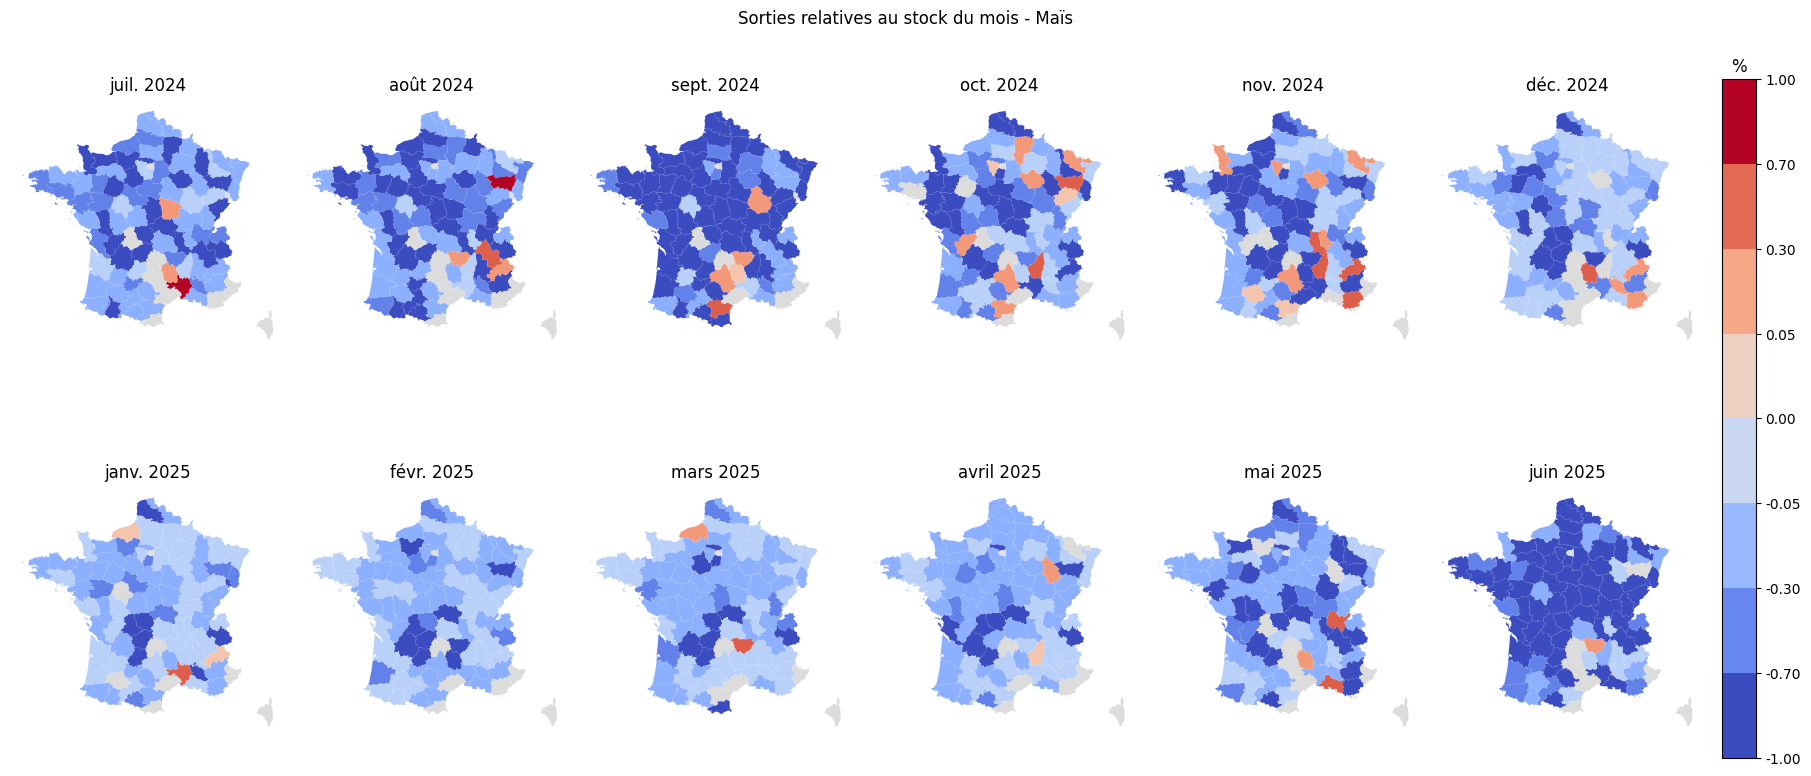

In [38]:
# ------------------------- #
### User Input              #
# ------------------------- #
# Quantiles :

quant_bin = False
quant_num = 5

cmap = mpl.colormaps['coolwarm']

# ------------------------- #
# create st matrix
# ------------------------- #
st = famDataset.make_spatiotemporal_matrix(transformed_data = fam_data,
                                            geom_data = fam.geom_data, 
                                            especes=espece, 
                                            variable='SORTIE_ON_STOCKS')

# Select specific years:
col_trigger = [ii+3 + (map_year-2000)*12 for ii in range(12)]

time_name = st.columns[col_trigger]
title_name = [datetime.datetime.strftime(name,'%b %Y') for name in time_name]

# Add geometry to the trigger
col_trigger.insert(0,0)
current_st = st.iloc[:,col_trigger]

# ---------------- #
### Map visual
# ---------------- #

# bins for colors:
if(quant_bin):
    # compute quantile bin edges
    qc = mc.Quantiles(current_st.iloc[:,1:], k=quant_num)
    bins = list(qc.bins)  # these are the upper edges for each class
    # Add 0 
    bins.insert(len(bins)-1, np.float64(0))
else: 
    bins = [-1,-0.7,-0.3,-0.05,0,0.05,0.3,0.7,1]

fig, axes = plt.subplots(2, 6, figsize=(18, 8), constrained_layout=True)
axes = axes.ravel()

for ii in range(12):
    current_st.plot(
        time_name[ii],
        ax=axes[ii],
        scheme="UserDefined",
        cmap = cmap,
        classification_kwds={"bins": bins},
    )

    axes[ii].set_title(title_name[ii])
    axes[ii].axis("off")


### Legend - GPT generated

# Create one ScalarMappable for the colorbar using the same cmap and a BoundaryNorm for discrete bins
# Build labels for the legend from bin edges
cmap_for_colorbar = mpl.cm.ScalarMappable(norm=mpl.colors.BoundaryNorm(bins, cmap.N), cmap=cmap)
cmap_for_colorbar.set_array([])

# Add single colorbar to the figure
cbar = fig.colorbar(cmap_for_colorbar, ax=axes.tolist(), orientation="vertical", fraction=0.02, pad=0.01)
# Optional: set tick labels to show bin intervals
tick_locs = 0.5 * (np.concatenate(([0], bins)) + np.concatenate((bins, [bins[-1]])))  # not used by BoundaryNorm directly
# Better: set ticks at bin edges and label ranges
cbar.set_ticks(bins)
cbar.set_ticklabels([f"{bins[0]:.2f}" ] + [f"{b:.2f}" for b in bins[1:]])
cbar.ax.set_title("%")

fig.suptitle(f"Sorties relatives au stock du mois - {espece}")
plt.show()

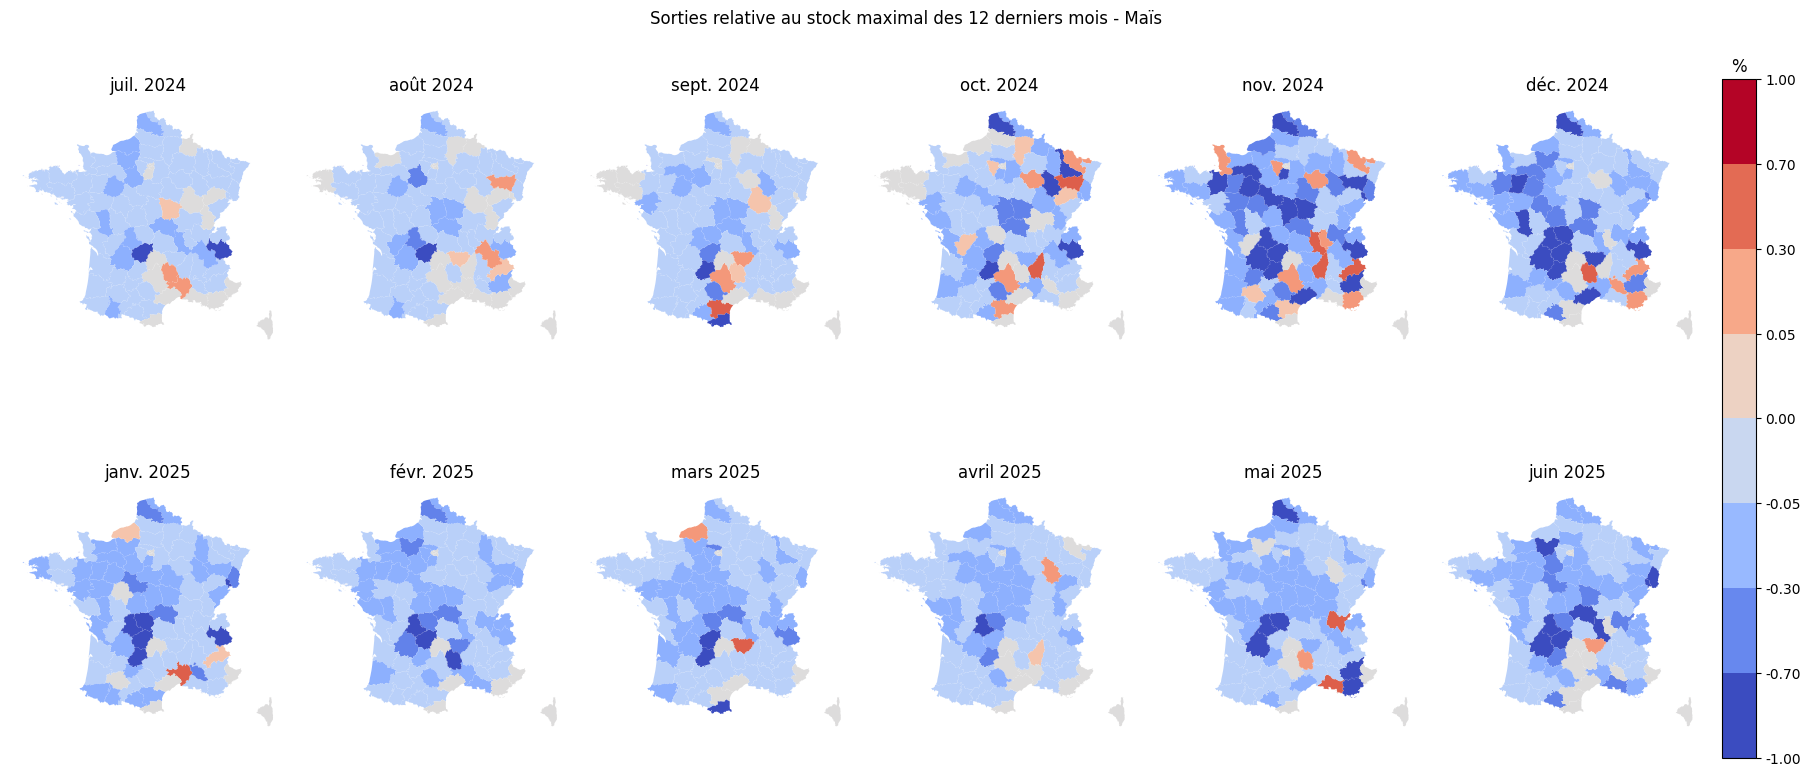

In [39]:
# ------------------------- #
### User Input              #
# ------------------------- #
# Quantiles :
quant_bin = False
quant_num = 5

cmap = mpl.colormaps['coolwarm']

# ------------------------- #
# create st matrix
# ------------------------- #
st = famDataset.make_spatiotemporal_matrix(transformed_data = fam_data,
                                            geom_data = fam.geom_data, 
                                            especes=espece, 
                                            variable='SORTIE_ON_MAX')

# Select specific years:
col_trigger = [ii+3 + (map_year-2000)*12 for ii in range(12)]

time_name = st.columns[col_trigger]
title_name = [datetime.datetime.strftime(name,'%b %Y') for name in time_name]

# Add geometry to the trigger
col_trigger.insert(0,0)
current_st = st.iloc[:,col_trigger]

# ---------------- #
### Map visual #####
# ---------------- #

# bins for colors:
if(quant_bin):
    # compute quantile bin edges
    qc = mc.Quantiles(current_st.iloc[:,1:], k=quant_num)
    bins = list(qc.bins)  # these are the upper edges for each class
    # Add 0 
    bins.insert(len(bins)-1, np.float64(0))
else: 
    bins = [-1,-0.7,-0.3,-0.05,0,0.05,0.3,0.7,1]


fig, axes = plt.subplots(2, 6, figsize=(18, 8), constrained_layout=True)
axes = axes.ravel()

for ii in range(12):
    current_st.plot(
        time_name[ii],
        ax=axes[ii],
        scheme="UserDefined",
        cmap = cmap,
        classification_kwds={"bins": bins},
    )

    axes[ii].set_title(title_name[ii])
    axes[ii].axis("off")


### Legend - GPT generated

# Create one ScalarMappable for the colorbar using the same cmap and a BoundaryNorm for discrete bins
# Build labels for the legend from bin edges
cmap_for_colorbar = mpl.cm.ScalarMappable(norm=mpl.colors.BoundaryNorm(bins, cmap.N), cmap=cmap)
cmap_for_colorbar.set_array([])

# Add single colorbar to the figure
cbar = fig.colorbar(cmap_for_colorbar, ax=axes.tolist(), orientation="vertical", fraction=0.02, pad=0.01)
# Optional: set tick labels to show bin intervals
tick_locs = 0.5 * (np.concatenate(([0], bins)) + np.concatenate((bins, [bins[-1]])))  # not used by BoundaryNorm directly
# Better: set ticks at bin edges and label ranges
cbar.set_ticks(bins)
cbar.set_ticklabels([f"{bins[0]:.2f}" ] + [f"{b:.2f}" for b in bins[1:]])
cbar.ax.set_title("%")

fig.suptitle(f"Sorties relative au stock maximal des 12 derniers mois - {espece}")
plt.show()

Aggregation des departements

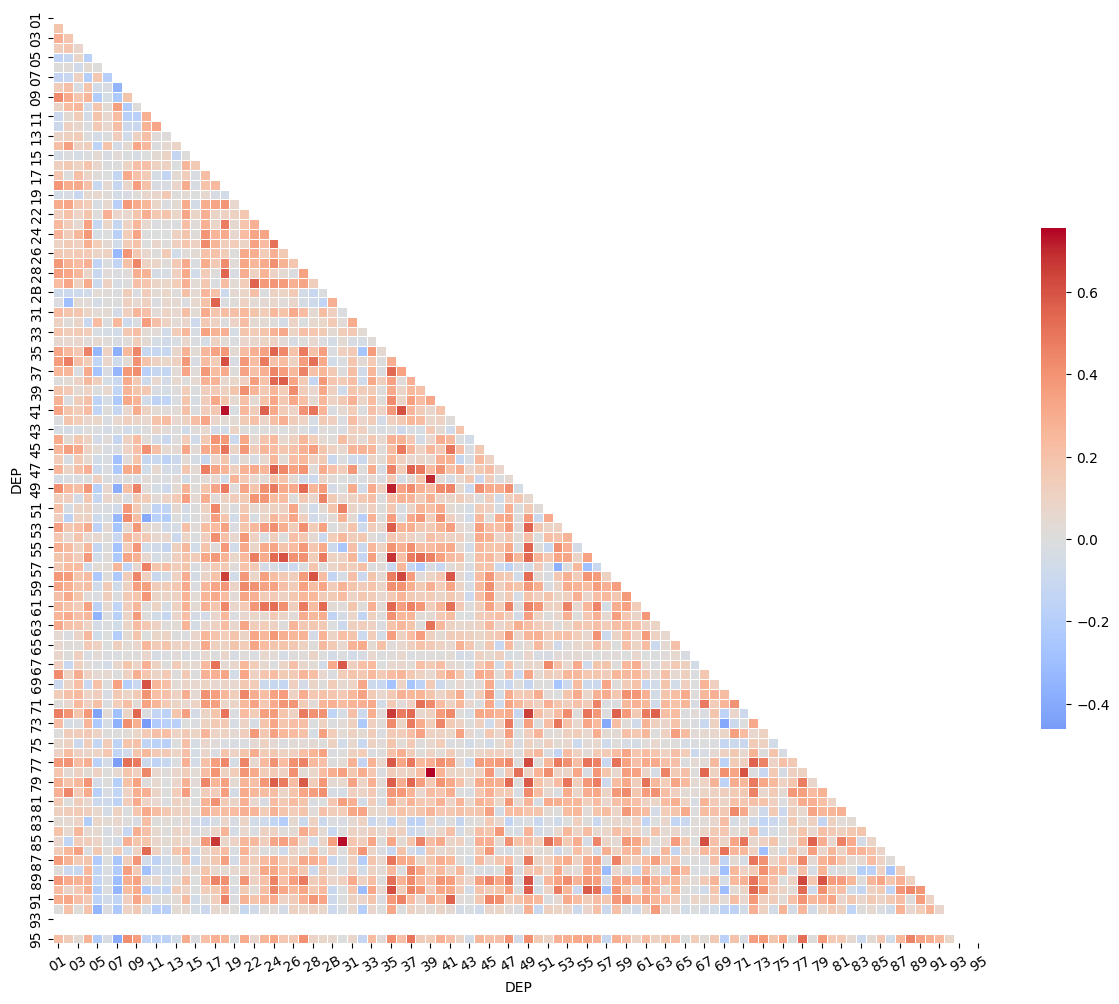

In [40]:
# Plotting a diagonal correlation matrix

st = famDataset.make_spatiotemporal_matrix(transformed_data = fam_data,
                                            geom_data = fam.geom_data, 
                                            especes=espece, 
                                            variable='SORTIE_ON_MAX')


corr_mat = st.iloc[:,3:].T.corr(numeric_only = False)
corr_mat.index = corr_mat.columns = st['DEP']

f, ax = plt.subplots(figsize=(15, 13))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, cmap='coolwarm', center=0, mask = mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=30)

plt.show()

What can we see:

- Department 2A (Corse) and 93 (Ile de France) are null -> delete them
- Some departments have a negative correlation with most of the others -> reorder the matrix  

In [41]:
# Delete the departements with nan correlation
TriggerNA = (corr_mat.isna().sum(axis= 0)-corr_mat.shape[0] < 0)
st = st.loc[TriggerNA.values,:]

# Recompute correlation
corr_mat = st.iloc[:,3:].T.corr(numeric_only = True)
corr_mat.index = corr_mat.columns = st['DEP']

In [42]:
# Flatten the upper triangle of the correlation matrix
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
sorted_corr = upper_tri.unstack().dropna().sort_values(ascending=False)

print(sorted_corr)

DEP  DEP
78   39     0.755526
85   30     0.741000
41   18     0.736257
49   35     0.717221
48   39     0.703548
              ...   
73   57    -0.400009
     69    -0.412299
72   05    -0.426498
77   07    -0.447225
73   10    -0.460623
Length: 4278, dtype: float64


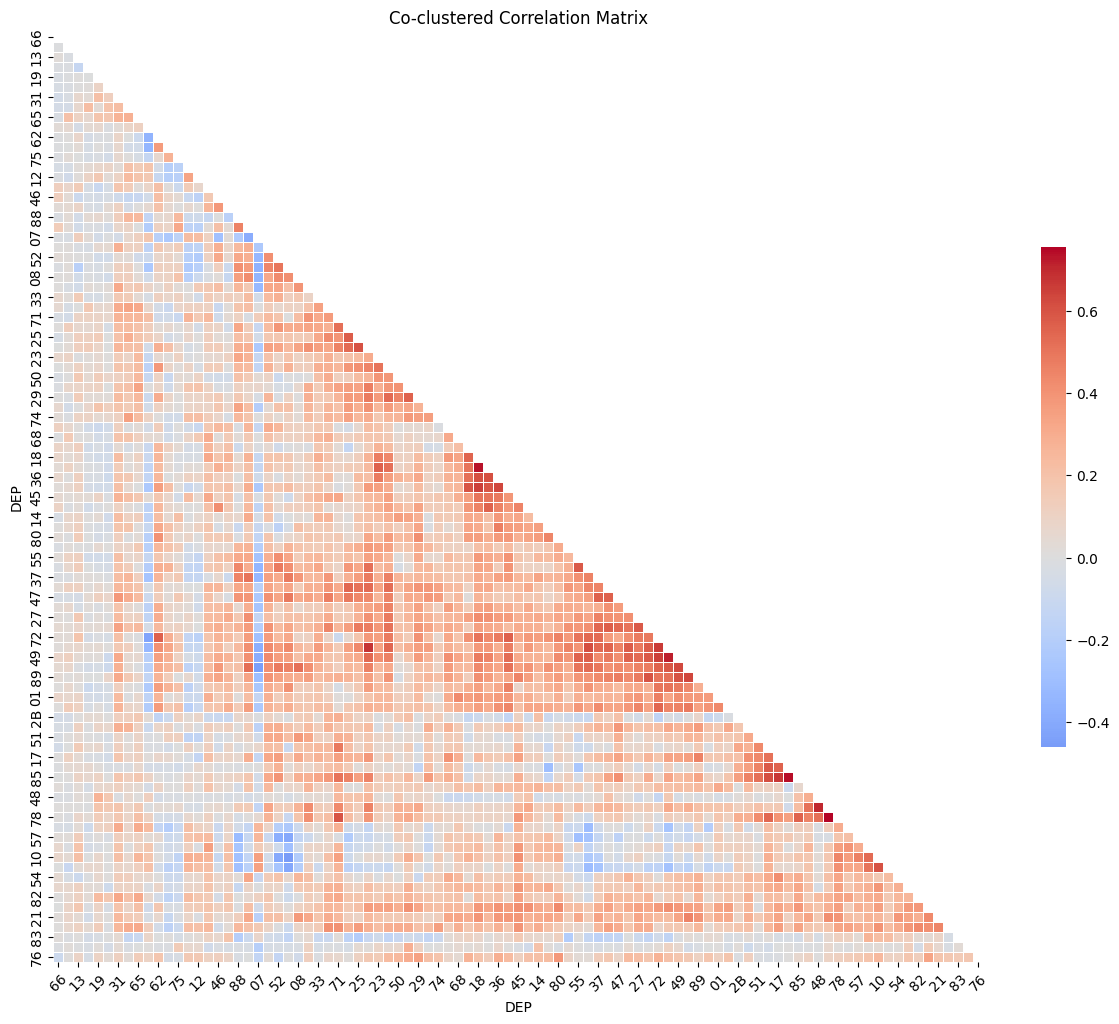

In [43]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Compute the distance matrix
distMatrix = 1 - abs(corr_mat)

# Perform hierarchical clustering
linkage = hierarchy.linkage(squareform(distMatrix), method='average')

# Get the order of rows/columns for the clustered matrix
order = hierarchy.dendrogram(linkage, no_plot=True)['leaves']

# Reorder the correlation matrix
clustered_corr = corr_mat.iloc[order, order]

# Plot the co-clustered correlation matrix
plt.figure(figsize=(15, 13))
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

sns.heatmap(clustered_corr, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45)
plt.title('Co-clustered Correlation Matrix')
plt.show()

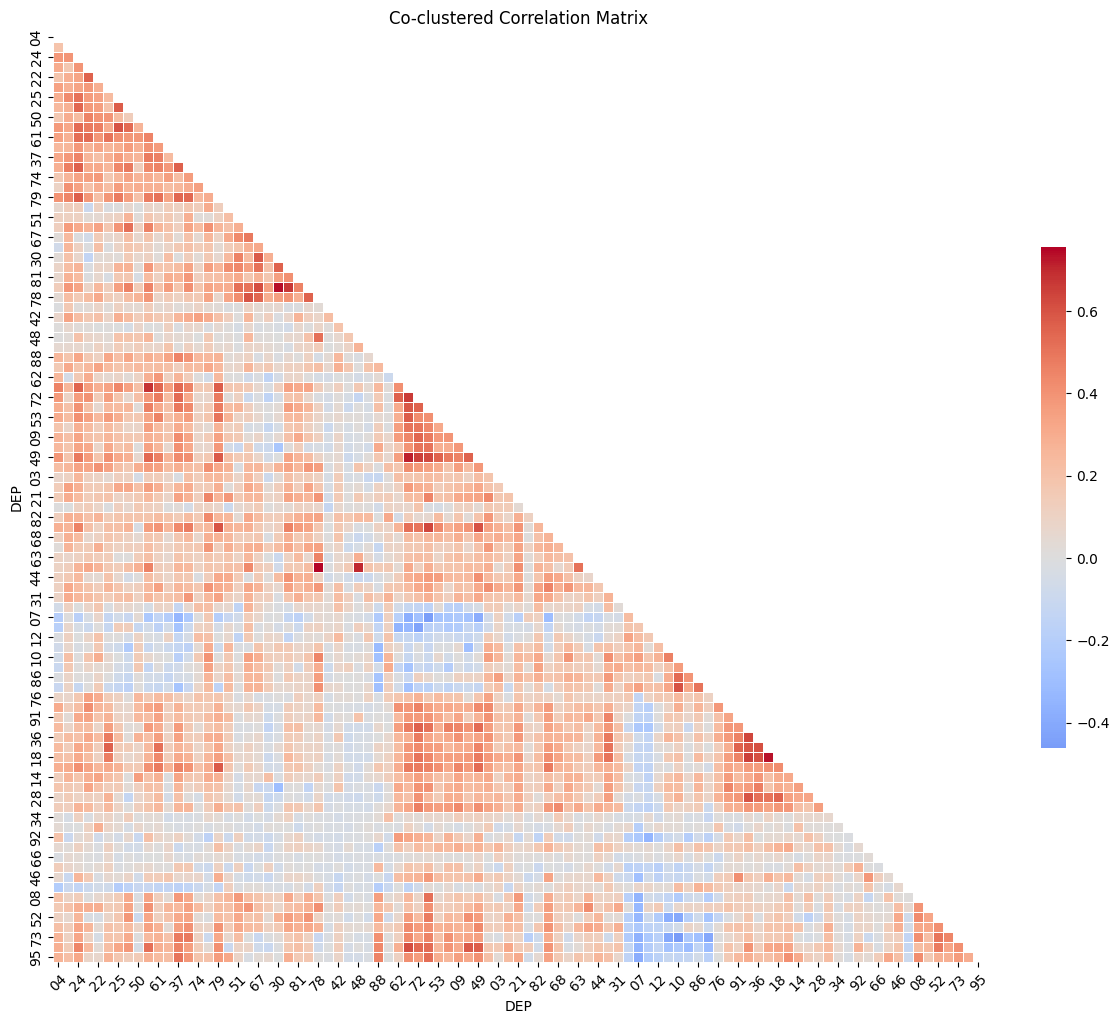

In [44]:

# SPECTRAL clustering

from sklearn.cluster import SpectralCoclustering

# Perform spectral co-clustering
n_clusters = 10 # Adjust based on your data
model = SpectralCoclustering(n_clusters=n_clusters, random_state=0)
model.fit(corr_mat)

# Get the row and column indices of the clusters
row_idx = np.argsort(model.row_labels_)
col_idx = np.argsort(model.column_labels_)

# Reorder the correlation matrix
clustered_corr = corr_mat.iloc[row_idx, col_idx]

# Plot the co-clustered correlation matrix
plt.figure(figsize=(15, 13))

mask = np.triu(np.ones_like(corr_mat, dtype=bool))

sns.heatmap(clustered_corr, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45)

plt.title('Co-clustered Correlation Matrix')
plt.show()

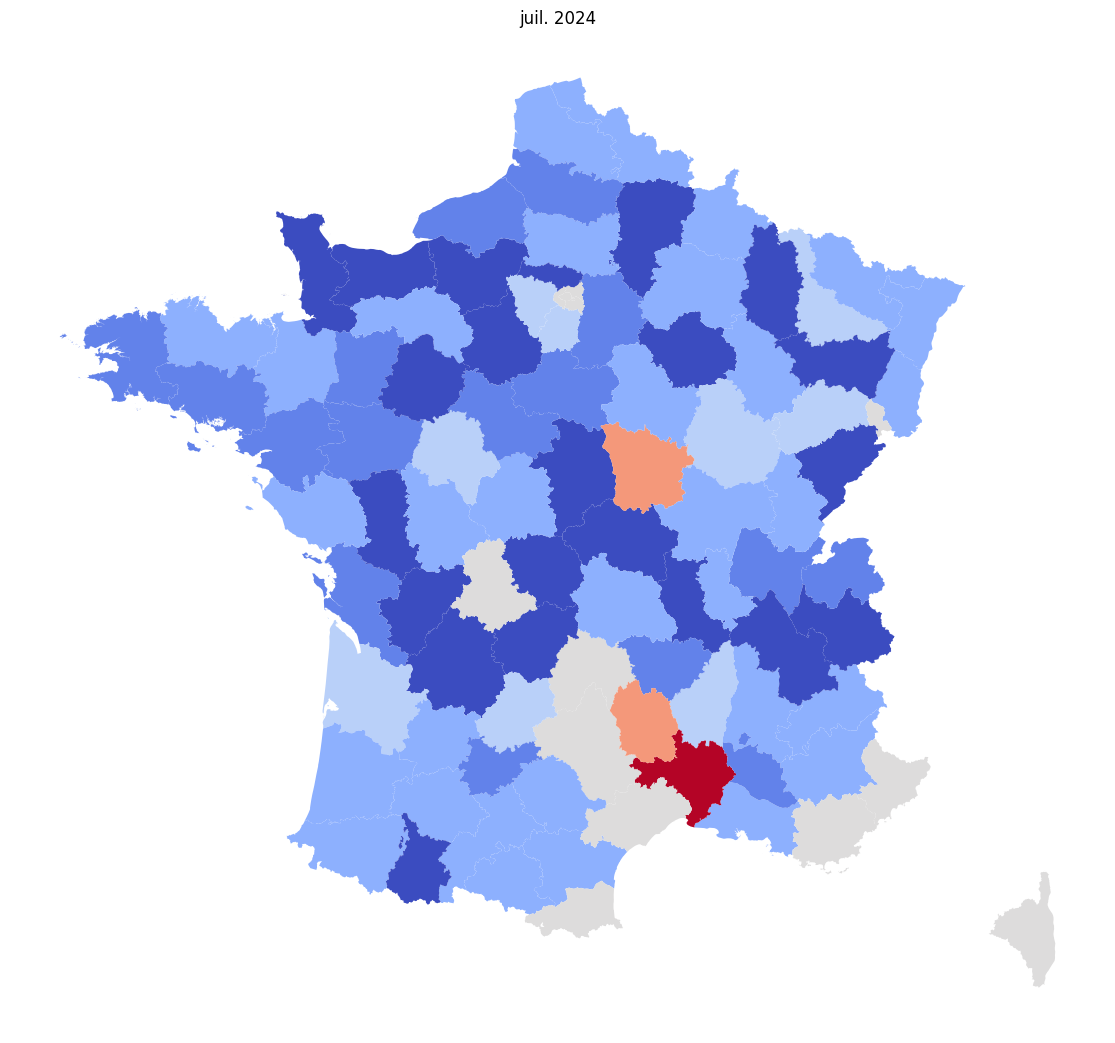

In [45]:
# ------------------------- #
### User Input              #
# ------------------------- #
# Quantiles :

quant_bin = False
quant_num = 5

cmap = mpl.colormaps['coolwarm']

# ------------------------- #
# create st matrix
# ------------------------- #
st = famDataset.make_spatiotemporal_matrix(transformed_data = fam_data,
                                            geom_data = fam.geom_data, 
                                            especes=espece, 
                                            variable='SORTIE_ON_STOCKS')

# Select specific years:
col_trigger = [ii+3 + (map_year-2000)*12 for ii in range(12)]

time_name = st.columns[col_trigger]
title_name = [datetime.datetime.strftime(name,'%b %Y') for name in time_name]

# Add geometry to the trigger
col_trigger.insert(0,0)
current_st = st.iloc[:,col_trigger]

# ---------------- #
### Map visual
# ---------------- #

# bins for colors:
if(quant_bin):
    # compute quantile bin edges
    qc = mc.Quantiles(current_st.iloc[:,1:], k=quant_num)
    bins = list(qc.bins)  # these are the upper edges for each class
    # Add 0 
    bins.insert(len(bins)-1, np.float64(0))
else: 
    bins = [-1,-0.7,-0.3,-0.05,0,0.05,0.3,0.7,1]



g = current_st.plot(
    time_name[0],
    scheme="UserDefined",
    cmap = cmap,figsize=(15, 13),
    classification_kwds={"bins": bins}
)

g.set_title(title_name[0])
g.axis("off")

plt.show()

